# Economic Stress Scoring Model
The goal of this model is to provide early earnings for recession.  I use a negative real GDP growth rate as a proxy for the recession.

## Data Assumptions
This model uses a LSTM neural network model to predict the probability that a month has negative real GDP growth rate.  The model uses macroeconomic data from Federal Reserve St. Louis.  Recession happens so rarely that we would like to use history as long as possible.

Because the Fed only releases quarterly real GDP growth, an interpolation of the data is applied: When a quarter suffers negative growth, we assume all three months suffer negative growth.  This interpolation allows us to utilize monthly data from June 1976 to train our neural network.

The following variables are used for prediction:
* **Unemployment Rate**
* **Unemployment Rate: Women**
* **Unemployment Rate: Aged 15-64: All Persons for the United States**
* **Unemployment Rate: 20 years and over, Black or African American Men**
* **Civilian Labor Force Participation Rate**
* **Civilian Labor Force Participation Rate: 25 to 54 years**
* **Civilian Labor Force Participation Rate: Women**
* **Civilian Unemployment Rate**
* **1-Year Treasury Constant Maturity Rate**
* **2-Year Treasury Constant Maturity Rate**
* **5-Year Treasury Constant Maturity Rate**
* **10-Year Treasury Constant Maturity Rate**
* **Moody's Seasoned Baa Corporate Bond Yield Relative to Yield on 10-Year Treasury Constant Maturity**
* **Moody's Seasoned Aaa Corporate Bond Yield Relative to Yield on 10-Year Treasury Constant Maturity**
* **Federal Funds Rate**

In [1]:
import pandas as pd
import numpy as np
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import datetime
start = datetime.datetime(1976, 6, 1)
end = datetime.datetime(2018, 8, 31)

# quarterly data
gdp = web.DataReader('A191RL1Q225SBEA', 'fred', start, end)
np.median(gdp)

# monthly covariates
sample = web.DataReader(
    [
    'UNRATE', 'LNS14000002', 'CIVPART', 'LNS11300060', 'LNU01300002',
    'UNEMPLOY', 'GS5', 'BAA10YM', 'AAA10YM', 'GS1', 
    'FEDFUNDS', 'LRUN64TTUSM156N', 'LNS14000031', 'GS10', 'GS2',
    ], 'fred', start, end)

We use NASDAQ and convert the daily data into volatility measured by the coefficient of variation.

In [2]:
# daily data
nasdaq = web.DataReader('NASDAQCOM', 'fred', start, end)

nasdaq['month'] = nasdaq.index.month
nasdaq['year'] = nasdaq.index.year
mu = nasdaq.groupby(['year', 'month']).aggregate(np.mean)
sigma = nasdaq.groupby(['year', 'month']).aggregate(np.std)

In [3]:
mon_nasdaq = mu.join(sigma, lsuffix = '_mean', rsuffix = '_std')
mon_nasdaq['nasdaq_vol'] = mon_nasdaq['NASDAQCOM_std']/mon_nasdaq['NASDAQCOM_mean'] * 100
mon_nasdaq.describe()
mon_nasdaq.index = pd.to_datetime(mon_nasdaq.index.map(lambda x: "-".join([str(x[0]), str(x[1]), "1"])))

In [4]:
sample = sample.join(mon_nasdaq['nasdaq_vol'])
sample.describe()

,UNRATE,LNS14000002,CIVPART,LNS11300060,LNU01300002,UNEMPLOY,GS5,BAA10YM,AAA10YM,GS1,FEDFUNDS,LRUN64TTUSM156N,LNS14000031,GS10,GS2,nasdaq_vol
count,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000
mean,6.308284,6.277909,65.110059,81.866075,56.771006,8390.021696,5.892544,2.248501,1.170355,5.066154,5.007554,6.392346,11.021893,6.336903,5.377258,2.051064
std,1.592190,1.495403,1.561821,2.129511,3.199056,2232.851139,3.492723,0.731986,0.559942,3.827940,4.071974,1.654747,3.128262,3.216947,3.775928,1.460727
min,3.800000,3.600000,61.500000,74.900000,47.200000,5481.000000,0.620000,0.930000,-0.170000,0.100000,0.070000,3.599570,5.900000,1.500000,0.210000,0.337075
25%,5.100000,5.100000,63.750000,81.000000,55.800000,6845.000000,2.875000,1.710000,0.780000,1.515000,1.260000,5.156618,8.800000,3.840000,1.910000,1.192290
50%,5.900000,5.900000,65.700000,82.700000,57.600000,7891.000000,5.780000,2.120000,1.110000,5.100000,5.220000,6.029603,10.400000,5.970000,5.360000,1.672159
75%,7.300000,7.450000,66.400000,83.400000,59.300000,8934.000000,8.105000,2.715000,1.600000,7.370000,7.255000,7.405182,12.900000,8.360000,7.770000,2.442731
max,10.800000,10.400000,67.300000,84.600000,60.400000,15352.000000,15.930000,6.010000,2.680000,16.720000,19.100000,11.591802,20.700000,15.320000,16.460000,15.973536


## Data Preprocessing

In [5]:
# data preprocessing
data = sample.join(gdp.applymap(lambda x: 1 if x < 0  else 0)) # define stressed as gdp growth rate less than 0%
# we need to do this because gdp growth rate is quarterly data
mon_gdp = data['A191RL1Q225SBEA'].values
mon_gdp[0] = 0

# impute quarterly gdp growth into monthly level
import math
for i in range(1, len(mon_gdp)):
    if math.isnan(mon_gdp[i]):
        mon_gdp[i] = mon_gdp[i-1]

data['gdp_growth'] = mon_gdp
data.drop('A191RL1Q225SBEA', axis = 1, inplace = True)

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
df = np.concatenate(
    [
        scaler.fit_transform(data.drop('gdp_growth', axis = 1).values.astype('float32')),
        np.array([data.gdp_growth.values.astype('float32')]).T
    ], axis = 1
)

In [7]:
def create_datasets(data, lookback):
    sample, target = [], []
    for i in range(len(data) - lookback - 1):
        d = data[i:(i + lookback - 1)]
        sample.append(d)
        target.append(data[i + lookback, 16])
    return np.array(sample), np.array(target)

In [8]:
from keras import layers
from keras import models
from keras import optimizers

Using TensorFlow backend.


In [9]:
sample, target = create_datasets(df, 36)
ix = int(np.ceil(0.8 * len(df)))
sample_train, target_train = sample[0:ix], target[0:ix]
sample_test, target_test = sample[ix:], target[ix:]

In [10]:
print(sample_train.shape)
print(target_train.shape)
_epochs = 40 # number of epochs to run through

(406, 35, 17)
(406,)


In [11]:
sample_train.shape

(406, 35, 17)

## LSTM Neural Network

In [12]:
from tensorflow import set_random_seed
set_random_seed(42)

# expect input [samples, time steps, features]
# parameters are optimized by grid search
model = models.Sequential()
model.add(layers.LSTM(64, input_shape = (sample_train.shape[1], sample_train.shape[-1])))
model.add(layers.Dense(1, activation = "sigmoid"))
model.compile(optimizer = optimizers.RMSprop(), loss = "binary_crossentropy", metrics = ['mae'])

out = model.fit(sample_train, target_train, epochs = _epochs, batch_size = 1, verbose = 2, 
                validation_data = (sample_test, target_test))

Train on 406 samples, validate on 64 samples
Epoch 1/40
 - 12s - loss: 0.4020 - mean_absolute_error: 0.2037 - val_loss: 0.2319 - val_mean_absolute_error: 0.1362
Epoch 2/40
 - 11s - loss: 0.3563 - mean_absolute_error: 0.1877 - val_loss: 0.2231 - val_mean_absolute_error: 0.1261
Epoch 3/40
 - 11s - loss: 0.3351 - mean_absolute_error: 0.1779 - val_loss: 0.2051 - val_mean_absolute_error: 0.0845
Epoch 4/40
 - 11s - loss: 0.3213 - mean_absolute_error: 0.1672 - val_loss: 0.2217 - val_mean_absolute_error: 0.0594
Epoch 5/40
 - 11s - loss: 0.3247 - mean_absolute_error: 0.1639 - val_loss: 0.2266 - val_mean_absolute_error: 0.1291
Epoch 6/40
 - 11s - loss: 0.3205 - mean_absolute_error: 0.1668 - val_loss: 0.2545 - val_mean_absolute_error: 0.1735
Epoch 7/40
 - 11s - loss: 0.3205 - mean_absolute_error: 0.1628 - val_loss: 0.2452 - val_mean_absolute_error: 0.0514
Epoch 8/40
 - 11s - loss: 0.3161 - mean_absolute_error: 0.1541 - val_loss: 0.2334 - val_mean_absolute_error: 0.1589
Epoch 9/40
 - 11s - loss: 0

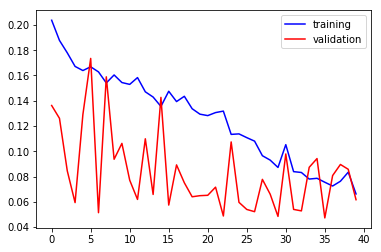

In [13]:
x = range(_epochs)
val = out.history['val_mean_absolute_error']
tra = out.history['mean_absolute_error']
# visualize prediction
from matplotlib import pyplot as plt
plt.plot(x, tra, 'b', label = 'training')
plt.plot(x, val, 'r', label = 'validation')
plt.legend()
plt.show()
# the model is probably overfit after epoch = 6

In [14]:
# recalibrate with the full data
from keras.backend import clear_session
clear_session()
model = models.Sequential()
model.add(layers.LSTM(64, input_shape = (sample.shape[1], sample.shape[-1])))
model.add(layers.Dense(1, activation = "sigmoid"))
model.compile(optimizer = optimizers.RMSprop(), loss = "binary_crossentropy", metrics = ['mae'])

out = model.fit(sample, target, epochs = 6, batch_size = 1, verbose = 2,)

Epoch 1/6
 - 12s - loss: 0.3665 - mean_absolute_error: 0.1840
Epoch 2/6
 - 12s - loss: 0.3296 - mean_absolute_error: 0.1610
Epoch 3/6
 - 12s - loss: 0.3264 - mean_absolute_error: 0.1655
Epoch 4/6
 - 12s - loss: 0.3261 - mean_absolute_error: 0.1536
Epoch 5/6
 - 12s - loss: 0.3062 - mean_absolute_error: 0.1545
Epoch 6/6
 - 12s - loss: 0.3227 - mean_absolute_error: 0.1575


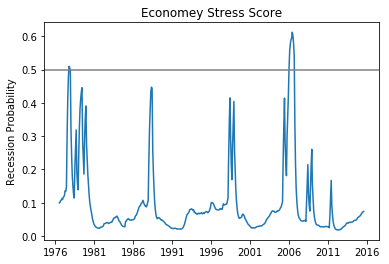

In [15]:
fit = model.predict(sample)
d0 = pd.date_range(start, end, freq = 'M')
plt.close()
plt.plot(d0[:(len(d0) - 37)], fit)
plt.axhline(y = 0.5, color = "grey")
plt.ylabel('Recession Probability')
plt.title('Economey Stress Score')
plt.show()

## LSTM Regulated by Dropouts


In [16]:
# model 2: LSTM
clear_session()
model = models.Sequential()
model.add(layers.LSTM(64, dropout = 0.2, recurrent_dropout = 0.1, input_shape = (sample_train.shape[1], sample_train.shape[-1])))
model.add(layers.Dense(1, activation = "sigmoid"))
model.compile(optimizer = optimizers.RMSprop(), loss = "binary_crossentropy", metrics = ['mae'])

out = model.fit(sample_train, target_train, epochs = _epochs, batch_size = 1, verbose = 2, 
                validation_data = (sample_test, target_test))

Train on 406 samples, validate on 64 samples
Epoch 1/40
 - 13s - loss: 0.4098 - mean_absolute_error: 0.1963 - val_loss: 0.2142 - val_mean_absolute_error: 0.1385
Epoch 2/40
 - 12s - loss: 0.3881 - mean_absolute_error: 0.1856 - val_loss: 0.2334 - val_mean_absolute_error: 0.1669
Epoch 3/40
 - 12s - loss: 0.3662 - mean_absolute_error: 0.1747 - val_loss: 0.2208 - val_mean_absolute_error: 0.1598
Epoch 4/40
 - 12s - loss: 0.3715 - mean_absolute_error: 0.1782 - val_loss: 0.2114 - val_mean_absolute_error: 0.1494
Epoch 5/40
 - 12s - loss: 0.3447 - mean_absolute_error: 0.1760 - val_loss: 0.2006 - val_mean_absolute_error: 0.0875
Epoch 6/40
 - 12s - loss: 0.3474 - mean_absolute_error: 0.1700 - val_loss: 0.1921 - val_mean_absolute_error: 0.0836
Epoch 7/40
 - 12s - loss: 0.3540 - mean_absolute_error: 0.1590 - val_loss: 0.2329 - val_mean_absolute_error: 0.1724
Epoch 8/40
 - 12s - loss: 0.3422 - mean_absolute_error: 0.1687 - val_loss: 0.1939 - val_mean_absolute_error: 0.0832
Epoch 9/40
 - 12s - loss: 0

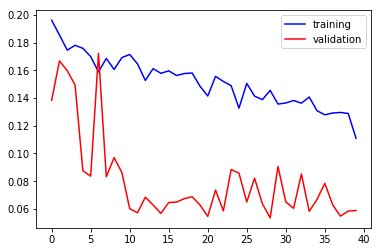

In [17]:
x = range(_epochs)
val = out.history['val_mean_absolute_error']
tra = out.history['mean_absolute_error']
# visualize prediction
from matplotlib import pyplot as plt
plt.plot(x, tra, 'b', label = 'training')
plt.plot(x, val, 'r', label = 'validation')
plt.legend()
plt.show()

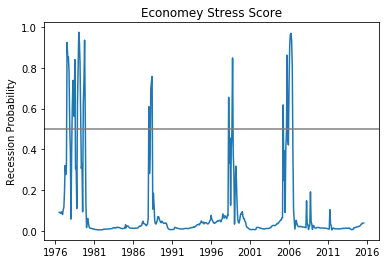

In [18]:
fit = model.predict(sample)
d0 = pd.date_range(start, end, freq = 'M')
plt.close()
plt.plot(d0[:(len(d0) - 37)], fit)
plt.axhline(y = 0.5, color = "grey")
plt.ylabel('Recession Probability')
plt.title('Economey Stress Score')
plt.show()

The model is able to capture the Energy Crisis of 1979, Black Monday 1987, Dot-com Bubble of 2000, and the Financial Crisis of 07-09.